```
This notebook sets up and runs a set of benchmarks to compare
different numerical discretizations of the SWEs

Copyright (C) 2016  SINTEF ICT

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

In [23]:
#Lets have matplotlib "inline"
%matplotlib inline

#Python 2.7 compatibility
from __future__ import print_function

#Import packages we need
import numpy as np
from matplotlib import animation, rc
from matplotlib import pyplot as plt
from matplotlib import gridspec
#import mpld3

import subprocess
import os
import gc
import datetime

import pycuda.driver as cuda

try:
    from StringIO import StringIO
except ImportError:
    from io import StringIO

#Finally, import our simulator
from SWESimulators import Common, LxF, FORCE, HLL, HLL2, KP07, KP07_dimsplit, WAF, PlotHelper

In [2]:
import atexit
def exitfunc():
    #Clean up old context if any:
    if 'cuda_context' in globals():
        print("Deleting existing context")
        global cuda_context
        del cuda_context
        gc.collect()
    else:
        print("No existing CUDA context")
        gc.collect()
        
atexit.register(exitfunc)
exitfunc()
    
cuda_context = Common.CudaContext(verbose=True, blocking=False)

No existing CUDA context
CUDA version (9, 1, 0)
Driver version 9010
Using GeForce 840M
 => compute capability: (5, 0)
 => memory: 2048.0 MB
Created context <1038205944592>


In [3]:
#Misc plotting setup
def setBwStyles(ax):
    from cycler import cycler

    ax.set_prop_cycle( cycler('marker', ['.', 'x', 4, '+', '*', '1', 5]) +
                       cycler('linestyle', ['-.', '--', ':', '-.', '--', ':', '-.']) +
                       #cycler('markersize', [5, 5, 5, 5, 5, 5]) +
                       cycler('color', ['k', 'k', 'k', 'k', 'k', 'k', 'k']) )    

#Set large figure sizes
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['animation.html'] = 'html5'
#plt.rcParams['legend.markerscale'] = 1.0
#plt.rcParams['lines.markersize'] = 6
plt.rcParams['lines.markeredgewidth'] = 1.5
#plt.rcParams['savefig.dpi'] = 400

In [4]:
def save_figure(fig, stem):
    fig_filename = "convergence_smooth1d_" + stem + ".pdf"
    
    image_text = fig_filename + "\nCreated " + str(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
    
    #ax = fig.gca()
    #pos1 = ax.get_position() # get the original position 
    #pos2 = [pos1.x0 + 0.3, pos1.y0 + 0.3,  pos1.width / 2.0, pos1.height / 2.0] 
    #ax.set_position(pos2) # set a new position
    
    #fig.gca().annotate(image_text, xy=(1.1, 0), xycoords='figure fraction', fontsize=10,
    #                   horizontalalignment='right', verticalalignment='bottom')
    t = plt.figtext(-0.1, .9, image_text, rotation='vertical')
    
    legend = fig.gca().legend_
    if (legend != None):
        fig.savefig(fig_filename, bbox_extra_artists=(legend,t, ), bbox_inches='tight')
    else:
        fig.savefig(fig_filename)

In [5]:
def gen_test_data(nx, ny, g, num_ghost_cells):
    width = 100.0
    height = 100.0
    dx = width / float(nx)
    dy = height / float(ny)

    x_center = dx*nx/2.0
    y_center = dy*ny/2.0
    
    h  = np.zeros((ny+2*num_ghost_cells, nx+2*num_ghost_cells), dtype=np.float32); 
    hu = np.zeros((ny+2*num_ghost_cells, nx+2*num_ghost_cells), dtype=np.float32);
    hv = np.zeros((ny+2*num_ghost_cells, nx+2*num_ghost_cells), dtype=np.float32);

    #Create a gaussian "dam break" that will not form shocks
    size = width / 5.0
    dt = 10**10
    for j in range(-num_ghost_cells, ny+num_ghost_cells):
        for i in range(-num_ghost_cells, nx+num_ghost_cells):
            x = dx*(i+0.5) - x_center
            y = dy*(j+0.5) - y_center
            
            h[j+num_ghost_cells, i+num_ghost_cells] = 0.5 + 0.1*np.exp(-(x**2/size))
            hu[j+num_ghost_cells, i+num_ghost_cells] = 0.1*np.exp(-(x**2/size))
            #if (x < 0):
            #    h[j+num_ghost_cells, i+num_ghost_cells] = 0.55 + 0.05*np.cos(np.minimum(1.0, -x/size)*np.pi)
            #    hu[j+num_ghost_cells, i+num_ghost_cells] = 0.0#- 0.05*(1 + np.cos(np.minimum(1.0, -x/size)*np.pi))
            #else:
            #    h[j+num_ghost_cells, i+num_ghost_cells] = 0.6
            #    hu[j+num_ghost_cells, i+num_ghost_cells] = 0.0#- 0.05*(1 + np.cos(np.minimum(1.0, x/size)*np.pi))
    
    scale = 0.7
    max_h_estimate = 0.6
    max_u_estimate = 0.1
    dt = scale * min(dx, dy) / (max_u_estimate + np.sqrt(g*max_h_estimate))
    
    return h, hu, hv, dx, dy, dt

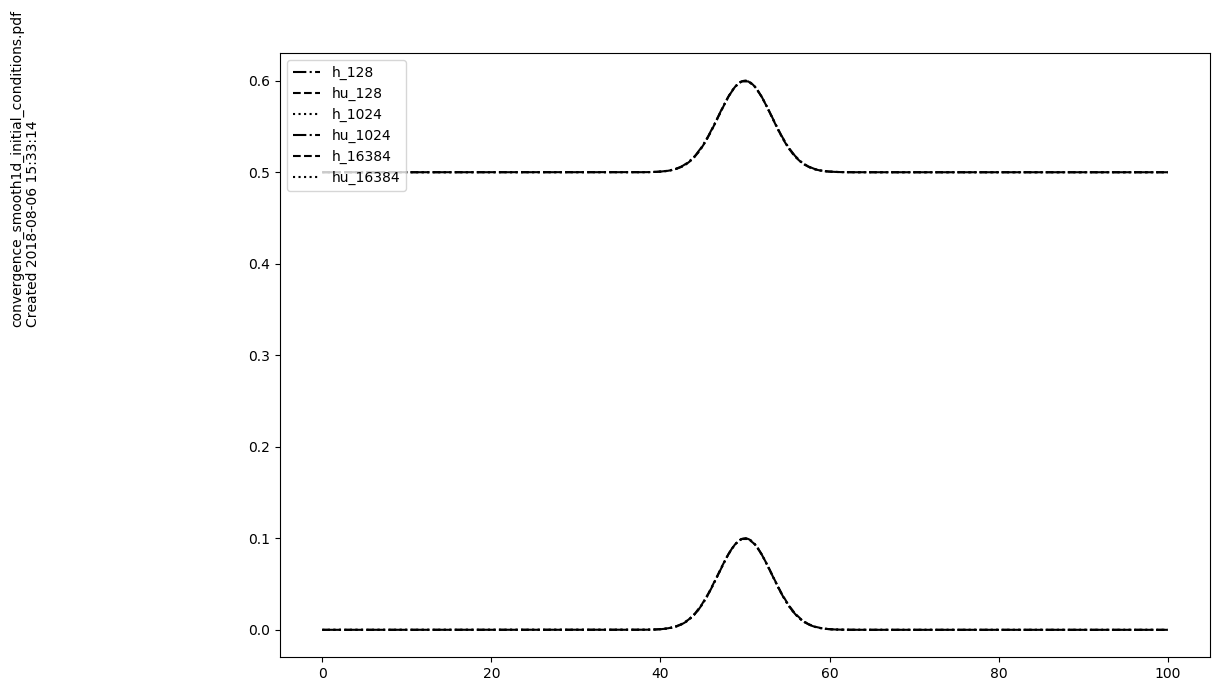

In [6]:
#Plot initial conditions            
fig = plt.figure()
setBwStyles(fig.gca())

for nx in [128, 1024, 16384]:
    h0, hu0, hv0, dx, dy, dt = gen_test_data(nx, 1, 9.81, 0)
    x = np.linspace(0.0, nx*dx, nx)
    
    #plt.subplot(211)
    plt.plot(x, h0.T, marker=' ', label='h_' + str(nx))
    plt.plot(x, hu0.T, marker=' ', label='hu_' + str(nx))
    #plt.subplot(212)
    #setBwStyles(fig.gca())
    #plt.plot(x, hu0.T, marker=" ", label='hu_' + str(nx))
    #plt.legend(loc='upper left')
    
#plt.xlim([47, 53])
#plt.ylim([0.58, 0.61])
plt.legend(loc='upper left')
save_figure(fig, 'initial_conditions')

In [7]:
def gen_filename(simulator, nx):
    return "smooth1d_" + str(simulator.__name__) + "_" + str(nx) + ".npz"

In [8]:
def sanity_check(variable, variable_name):
    maxval = np.amax(variable)
    minval = np.amin(variable)
    if (np.isnan(maxval) or np.isnan(minval)):
        print("=== WARNING ===")
        print(variable_name + " contains NaN values")
        print("=== WARNING ===")

def run_benchmark(datafilename, simulator, courant_number, nx, ny, ghost_cells, g=9.81, force_rerun=False):

    if (os.path.isfile(datafilename) and force_rerun == False):
        print("=== WARNING ===")
        print("Existing simulation exists, skipping simulation")
        print("=== WARNING ===")
    else:
        h0, hu0, hv0, dx, dy, dt = gen_test_data(nx, ny, g, ghost_cells)
        dt = dt * courant_number

        #Initialize simulator
        with Common.Timer(simulator.__name__ + "_" + str(nx)) as timer:
            sim = simulator(cuda_context, \
                            h0, hu0, hv0, \
                            nx, ny, \
                            dx, dy, dt, \
                            g)

            t, nt = sim.step(2.0)
            
            h, hu, hv = sim.download()

            h = h[ghost_cells, ghost_cells:-ghost_cells]
            hu = hu[ghost_cells, ghost_cells:-ghost_cells]
            hv = hv[ghost_cells, ghost_cells:-ghost_cells]
            
            sanity_check(h, "h")
            sanity_check(hu, "hu")
            sanity_check(hv, "hv")

            np.savez_compressed(datafilename, h=h, hu=hu, hv=hv)
        
    gc.collect() # Force run garbage collection to free up memory
    
    return [timer.secs, nt, dt]

In [9]:
reference_nx = 16384
domain_sizes = [16, 32, 64, 128, 256, 512, 1024, 2048, 4096]

simulators = [LxF.LxF, FORCE.FORCE, HLL.HLL, HLL2.HLL2, KP07.KP07, KP07_dimsplit.KP07_dimsplit, WAF.WAF]
simulator_ghost_cells = [1, 1, 1, 2, 2, 2, 2]
simulator_reference = [LxF.LxF, FORCE.FORCE, HLL.HLL, HLL2.HLL2, KP07.KP07, KP07_dimsplit.KP07_dimsplit, WAF.WAF]
simulator_courant_numbers = [0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9]
force_rerun=True

#reference_nx = 16384
#domain_sizes = [32, 64, 128, 256, 512, 1024]
#simulators = [HLL2.HLL2, WAF.WAF]
#simulator_ghost_cells = [2, 2]
#simulator_reference = [HLL2.HLL2, WAF.WAF]
#simulator_courant_numbers = [0.95, 0.95]
#force_rerun=True

sim_elapsed_time = np.zeros((len(simulators), len(domain_sizes)))
sim_dt = np.zeros((len(simulators), len(domain_sizes)))
sim_nt = np.zeros((len(simulators), len(domain_sizes)))

#Warmup to compile kernels
print("Warmup")
for i in range(len(simulators)):
    run_benchmark("warmup", \
                  simulators[i], \
                  simulator_courant_numbers[i], \
                  16, 1, \
                  simulator_ghost_cells[i], \
                  force_rerun=force_rerun)
    
print("Simulating")
for i in range(len(simulators)):        
    # Run the simulation for all the domain sizes
    for j, nx in enumerate(domain_sizes):
        datafilename = gen_filename(simulators[i], nx)
        [secs, nt, dt] = run_benchmark(datafilename, \
                      simulators[i], \
                      simulator_courant_numbers[i], \
                      nx, 1, \
                      simulator_ghost_cells[i], \
                      force_rerun=force_rerun)
        sim_elapsed_time[i, j] = secs
        sim_dt[i, j] = dt
        sim_nt[i, j] = nt
    
    # Run reference with a low CFL-number
    datafilename = gen_filename(simulators[i], reference_nx)
    run_benchmark(datafilename, \
                  simulators[i], \
                  simulator_courant_numbers[i] * 0.5, \
                  reference_nx, 1, \
                  simulator_ghost_cells[i], \
                  force_rerun=force_rerun)

Warmup


c:\Users\anbro\Documents\projects\ShallowWaterGPU\SWESimulators\Common.py:103: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu

  self.kernels[kernel_hash] = cuda_compiler.SourceModule(kernel_string, include_dirs=[module_path])


=> LxF_16 15839.982748 ms
=> FORCE_16 12674.291611 ms
=> HLL_16 13204.208612 ms
=> HLL2_16 13233.549595 ms
=> KP07_16 12692.486048 ms
=> KP07_dimsplit_16 12948.359013 ms
=> WAF_16 13000.165939 ms
Simulating
=> LxF_16 19.012451 ms
=> LxF_32 30.022144 ms
=> LxF_64 21.043777 ms
=> LxF_128 30.017376 ms
=> LxF_256 40.029526 ms
=> LxF_512 23.016453 ms
=> LxF_1024 37.027359 ms
=> LxF_2048 57.014227 ms
=> LxF_4096 134.095907 ms
=> LxF_16384 2909.069777 ms
=> FORCE_16 31.022310 ms
=> FORCE_32 47.033310 ms
=> FORCE_64 22.015095 ms
=> FORCE_128 29.020309 ms
=> FORCE_256 31.022310 ms
=> FORCE_512 64.047098 ms
=> FORCE_1024 34.024239 ms
=> FORCE_2048 112.079620 ms
=> FORCE_4096 163.116455 ms
=> FORCE_16384 4130.271673 ms
=> HLL_16 33.022642 ms
=> HLL_32 109.077692 ms
=> HLL_64 52.036285 ms
=> HLL_128 38.029909 ms
=> HLL_256 78.056335 ms
=> HLL_512 58.037281 ms
=> HLL_1024 53.039312 ms
=> HLL_2048 80.058336 ms
=> HLL_4096 254.181147 ms
=> HLL_16384 5170.261145 ms
=> HLL2_16 24.017334 ms
=> HLL2_32 1

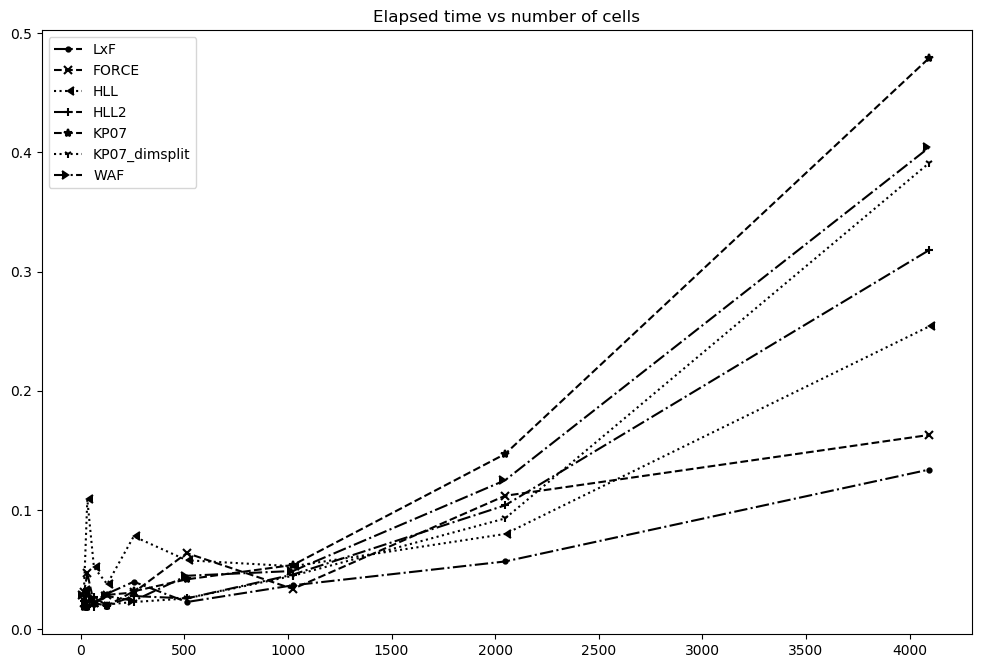

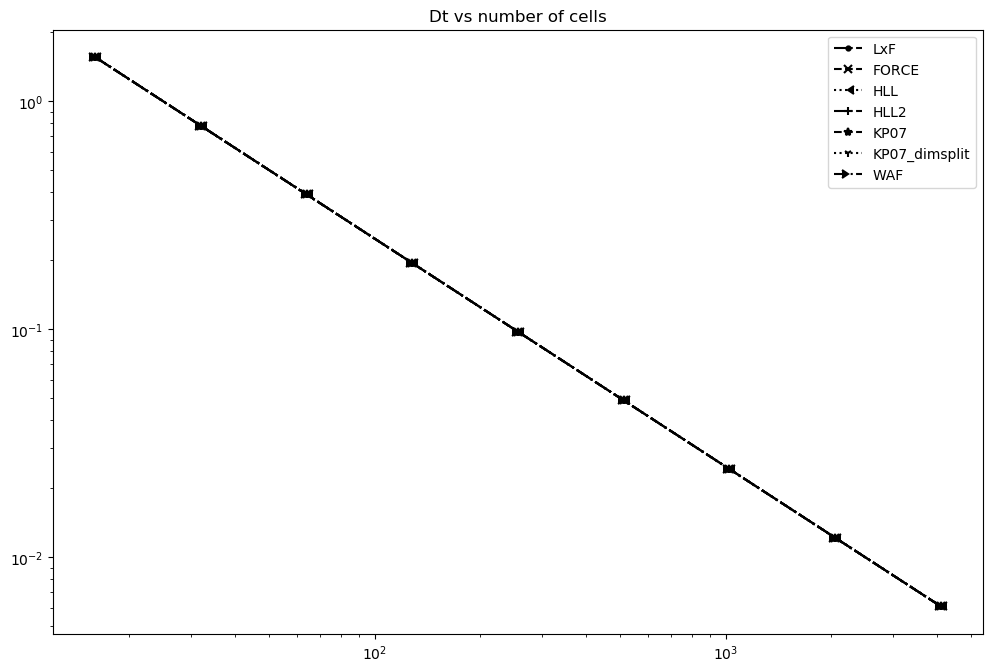

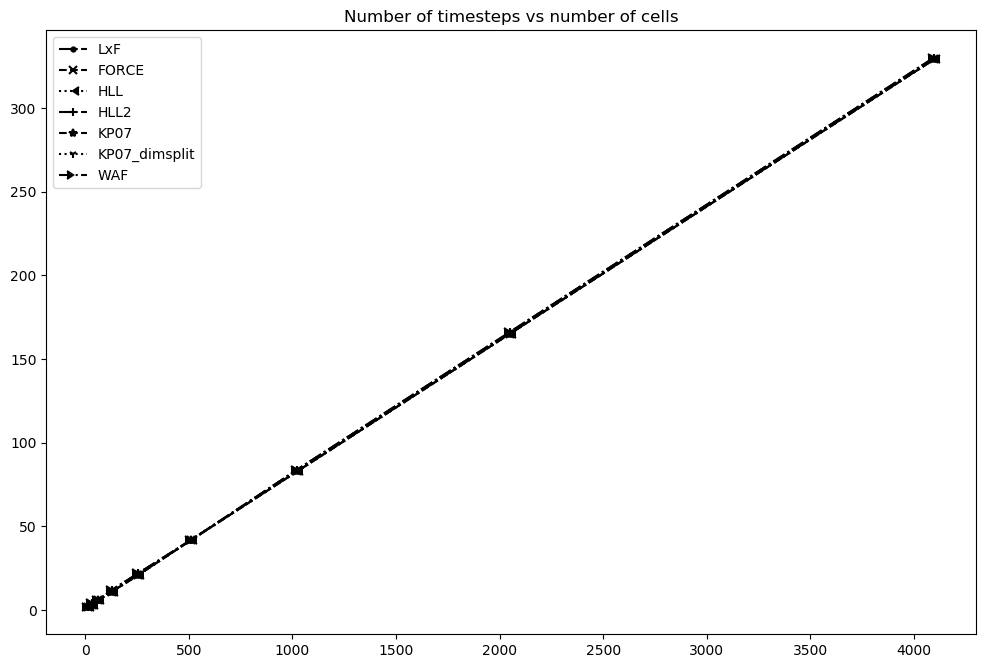

In [22]:
fig = plt.figure()
setBwStyles(fig.gca())
plt.title("Elapsed time vs number of cells")
for i, simulator in enumerate(simulators):
    plt.plot(domain_sizes, sim_elapsed_time[i,:], label=simulator.__name__)
plt.legend()
    
fig = plt.figure()
setBwStyles(fig.gca())
plt.title("Dt vs number of cells")
for i, simulator in enumerate(simulators):
    plt.loglog(domain_sizes, sim_dt[i,:], label=simulator.__name__)
plt.legend()
    
fig = plt.figure()
setBwStyles(fig.gca())
plt.title("Number of timesteps vs number of cells")
for i, simulator in enumerate(simulators):
    plt.plot(domain_sizes, sim_nt[i,:], label=simulator.__name__)
plt.legend()

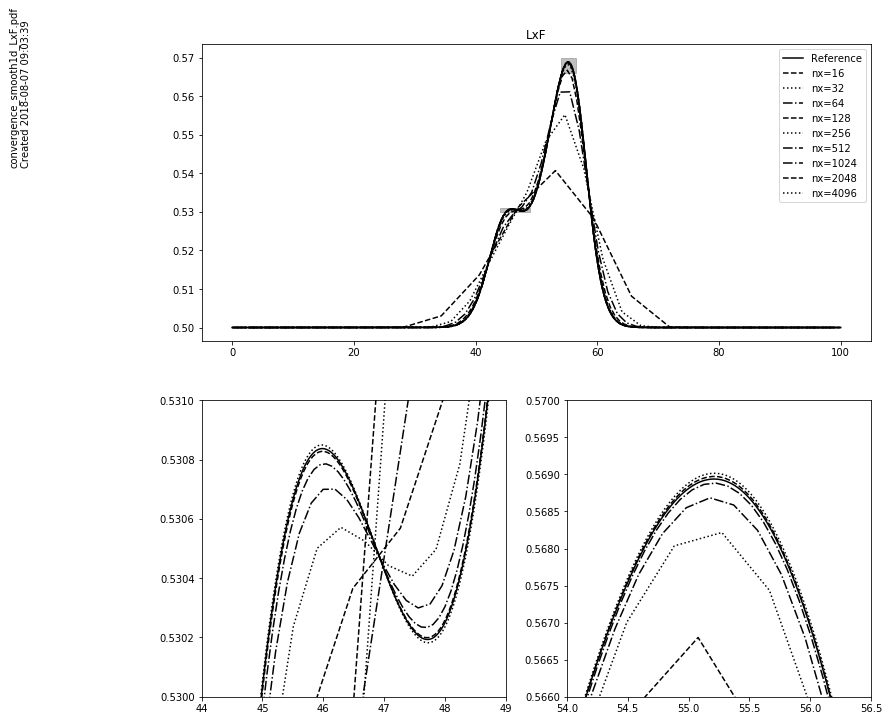

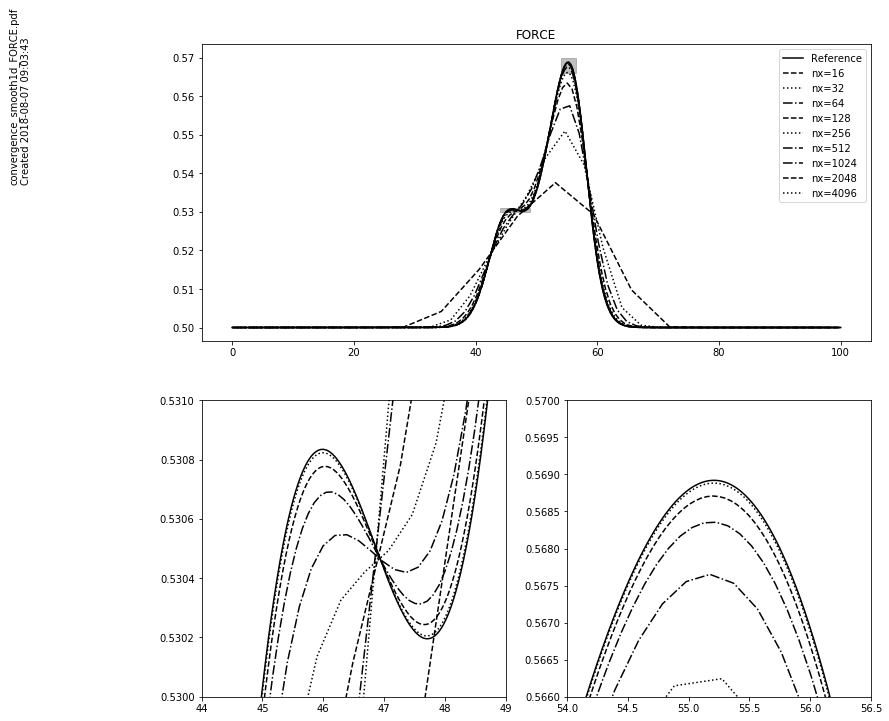

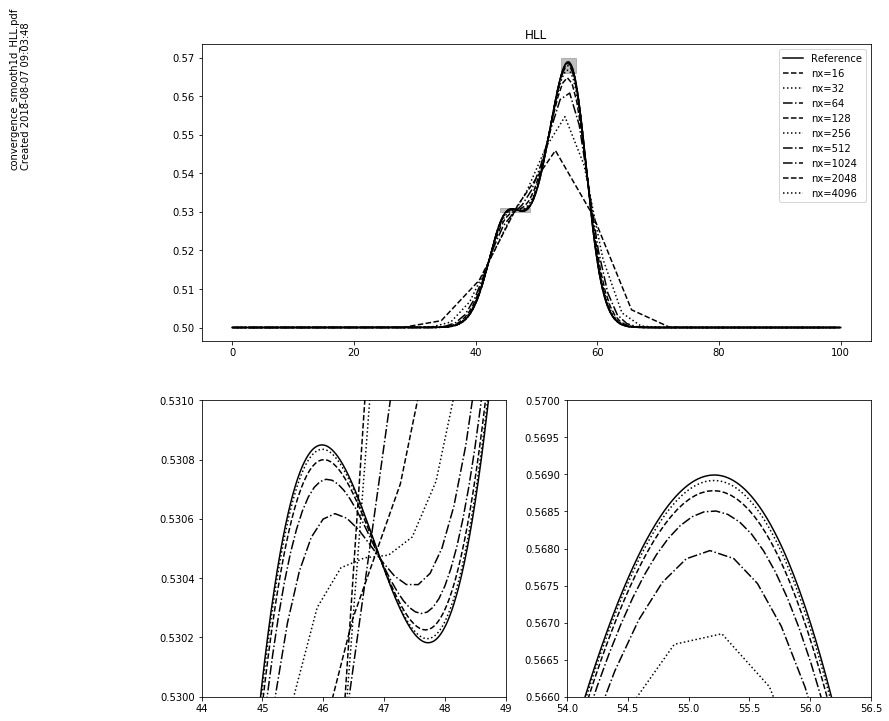

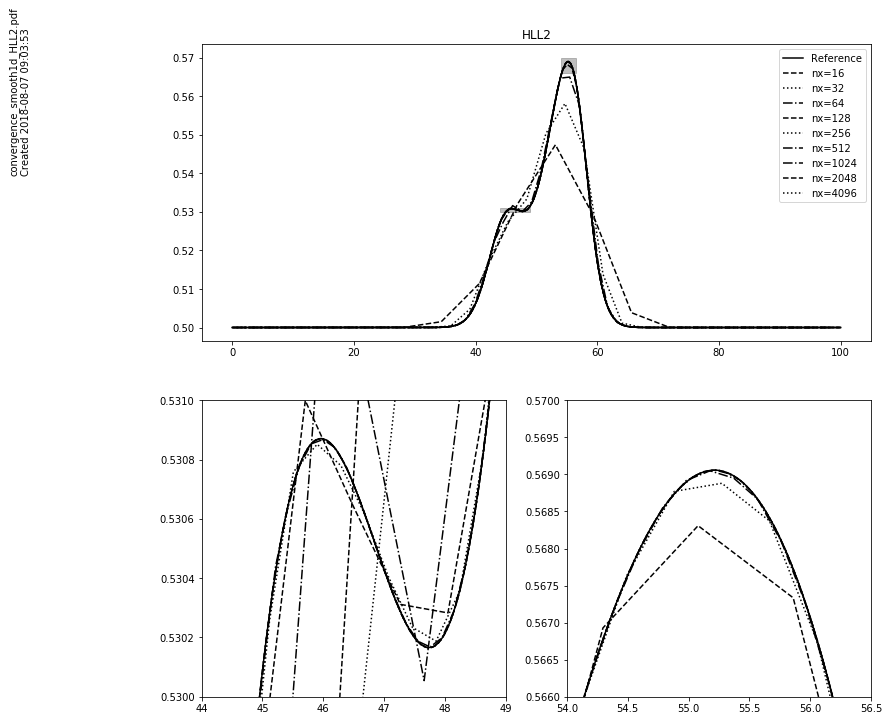

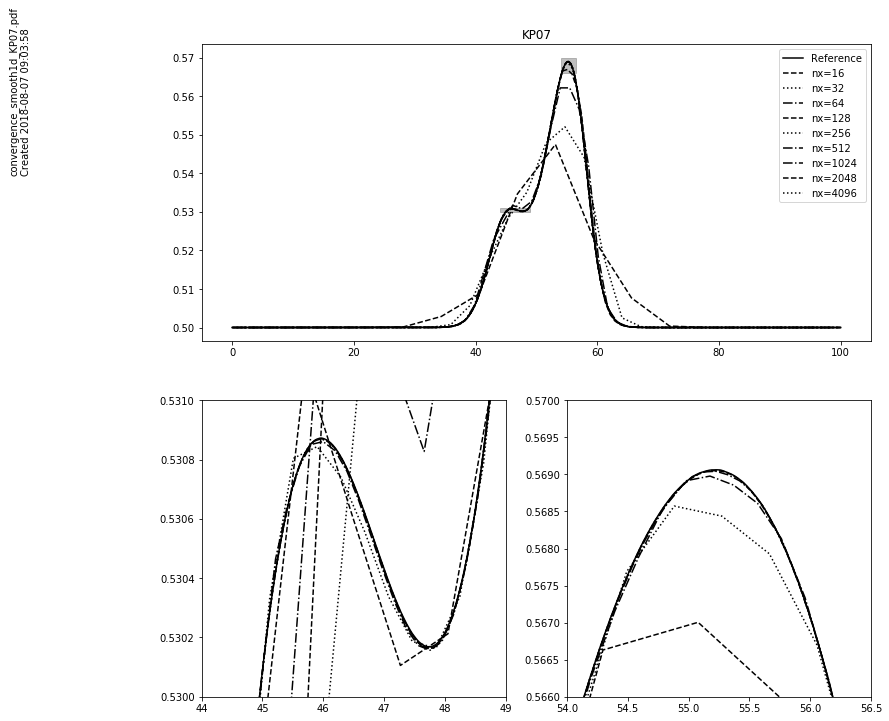

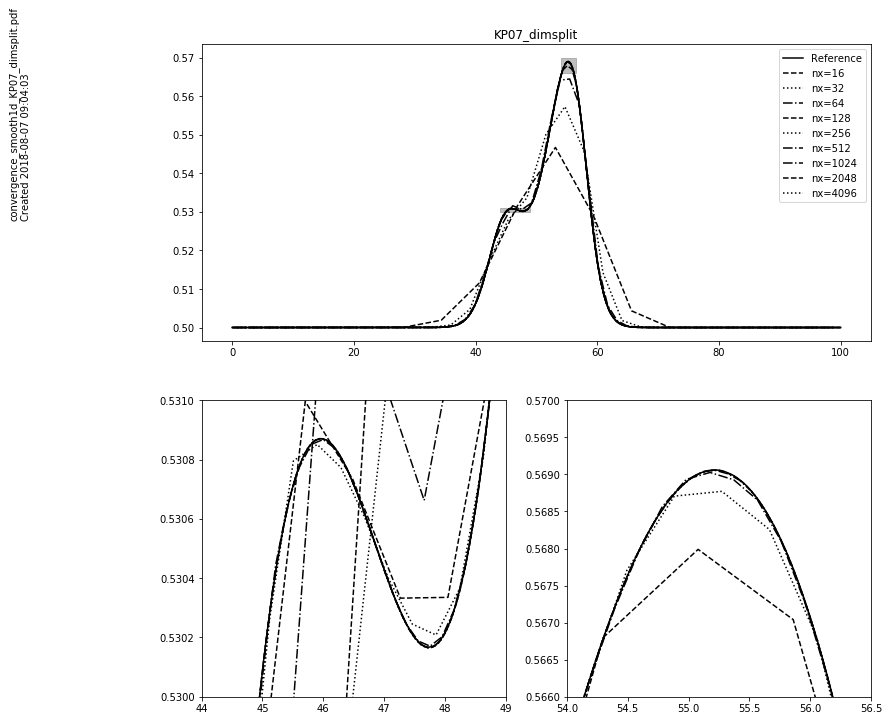

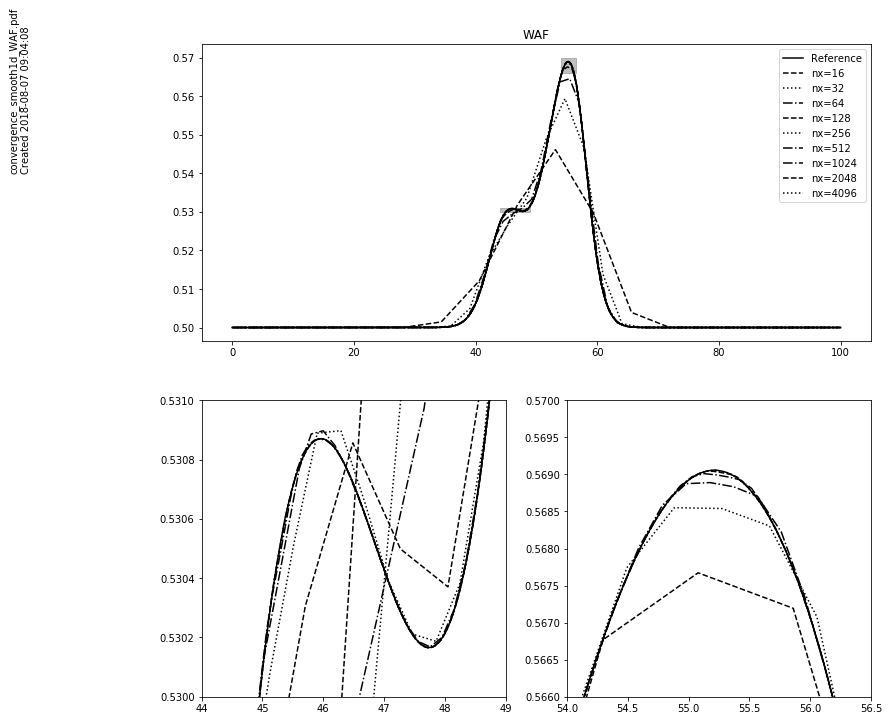

In [32]:
def plot_solution(simulator, nx, label, **kwargs):
    datafilename = gen_filename(simulator, nx)
    
    #Read the solution
    with np.load(datafilename) as data:
        h = data['h']
        
    x = np.linspace(0.5, nx-0.5, nx)*100.0/float(nx)
    
    plt.plot(x, h, label=label, **kwargs)
    
    h = None
    x = None
    gc.collect() # Force run garbage collection to free up memory
    
    
boxes = np.array([\
         [[44, 49], [0.53, 0.531]], \
         [[54, 56.5], [0.566, 0.57]]
         ])

for simulator in simulators:
    fig = plt.figure(figsize=(12, 12))
    
    gs = gridspec.GridSpec(2, 2)
    
    ax1 = fig.add_subplot(gs[0,:])
    setBwStyles(ax1)
    plot_solution(simulator, reference_nx, 'Reference', linestyle='-', marker=' ')
    for j, nx in enumerate(domain_sizes):
        plot_solution(simulator, nx, 'nx=' + str(nx), marker=' ')
    for box_x, box_y in boxes:
        x = np.kron(box_x, np.ones((2)))
        y = np.hstack((box_y, box_y[::-1]))
        fig.gca().fill(x, y, fill=True, linestyle='-', color='gray', alpha=0.5)
    plt.title(str(simulator.__name__))
    plt.legend()
    
    ax2 = fig.add_subplot(gs[1,0])
    setBwStyles(ax2)
    plot_solution(simulator, reference_nx, 'Reference', linestyle='-', marker=' ')
    for j, nx in enumerate(domain_sizes):
        plot_solution(simulator, nx, 'nx=' + str(nx), marker=' ')  
    plt.xlim(boxes[0, 0])
    plt.ylim(boxes[0, 1])
    
    ax3 = fig.add_subplot(gs[1,1])
    setBwStyles(ax3)
    plot_solution(simulator, reference_nx, 'Reference', linestyle='-', marker=' ')
    for j, nx in enumerate(domain_sizes):
        plot_solution(simulator, nx, 'nx=' + str(nx), marker=' ')   
    plt.xlim(boxes[1, 0])
    plt.ylim(boxes[1, 1])
    
    save_figure(fig, simulator.__name__)

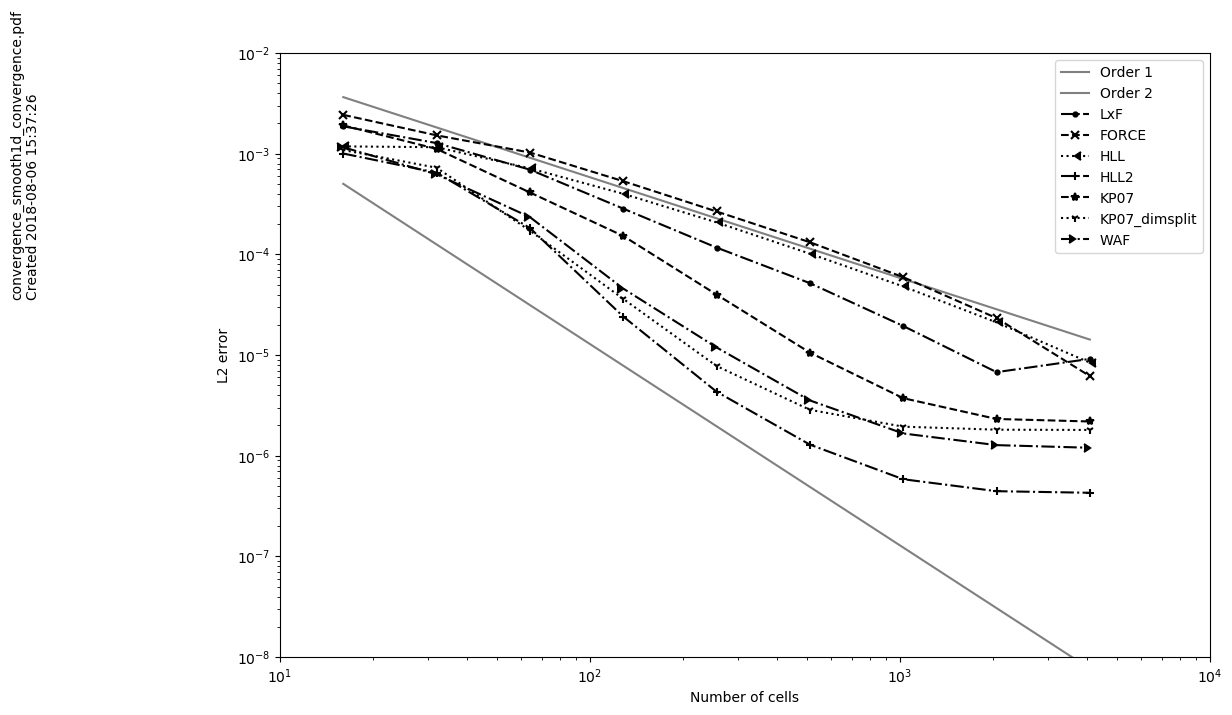

In [12]:
def downsample(highres_solution, factor):
    assert(highres_solution.size % factor == 0)
    nx = highres_solution.size / factor
    return highres_solution.reshape([int(nx), int(factor)]).mean(1)

conservation = np.zeros((len(simulators), len(domain_sizes)))
error = np.zeros((len(simulators), len(domain_sizes)))
order = np.zeros((len(simulators), len(domain_sizes)-1))

for i, simulator in enumerate(simulators):
    #Read the reference solution
    datafilename = gen_filename(simulator, reference_nx)
    with np.load(datafilename) as data:
        h_ref = data['h']
    
    #Compute conservation and error for subsequent resolutions
    for j, nx in enumerate(domain_sizes):
        #Read current resolution
        datafilename = gen_filename(simulator, nx)
        with np.load(datafilename) as data:
            h = data['h']
        
        #Downsample reference to current resolution
        h_ref_downsampled = downsample(h_ref, reference_nx/nx)
        
        #Compute error per cell
        error[i, j] = np.linalg.norm(np.abs(h_ref_downsampled - h), ord=1) / nx
        conservation[i, j] = (np.sum(h_ref_downsampled) - np.sum(h))
    
    #Compute the numerical order
    a = np.arange(1, len(domain_sizes))
    order[i,:] = np.log2(error[i, :-1] / error[i, 1:])
    
fig = plt.figure()
setBwStyles(fig.gca())

x = np.linspace(domain_sizes[0], domain_sizes[-1], 100);

scaling = np.max(error[:,0]) * domain_sizes[0] * 1.5
plt.loglog(x, scaling/x, '-', color='gray', label='Order 1')

scaling = np.min(error[:,0]) * domain_sizes[0]**2 * 0.5
plt.loglog(x, scaling/(x*x), '-', color='gray', label='Order 2')

for i, simulator in enumerate(simulators):
    plt.loglog(domain_sizes, error[i,:], label=simulators[i].__name__)
    
plt.axis([10**1, 10**4, 10**-8, 10**-2])
plt.xlabel('Number of cells')
plt.ylabel('Error')
plt.title("Convergence")
plt.legend()
save_figure(fig, 'convergence')

In [13]:
import pandas as pd
from IPython.display import display

print("Numerical order")
for i, simulator in enumerate(simulators):
    print("{}, max={:1.2f}, min={:1.2f}, mean={:1.2f}".format(
        simulator.__name__, 
        np.max(order[i,:]), 
        np.min(order[i,:]), 
        np.mean(order[i,:])))

table = pd.DataFrame(order, columns=domain_sizes[:-1], index=[simulator.__name__ for simulator in simulators])
display(table)

Numerical order
LxF, max=1.52, min=-0.44, mean=0.96
FORCE, max=1.92, min=0.57, mean=1.08
HLL, max=1.33, min=0.03, mean=0.89
HLL2, max=2.92, min=0.05, mean=1.40
KP07, max=1.93, min=0.08, mean=1.22
KP07_dimsplit, max=2.25, min=0.01, mean=1.15
WAF, max=2.36, min=0.09, mean=1.24


,16,32,64,128,256,512,1024,2048
LxF,0.551766,0.877245,1.286131,1.284833,1.173928,1.414042,1.523252,-0.437539
FORCE,0.675693,0.567261,0.945584,0.999597,1.015042,1.151907,1.349826,1.915498
HLL,0.027470,0.697934,0.840046,0.942534,1.032673,1.081559,1.186035,1.327588
HLL2,0.631096,1.826702,2.921143,2.479654,1.746974,1.142136,0.394630,0.052195
KP07,0.775602,1.437606,1.435047,1.934508,1.914323,1.504337,0.686125,0.083406
KP07_dimsplit,0.584112,2.076535,2.250786,2.215593,1.446163,0.555648,0.099595,0.008641
WAF,0.892681,1.412418,2.357570,1.942082,1.749053,1.090527,0.384555,0.087031


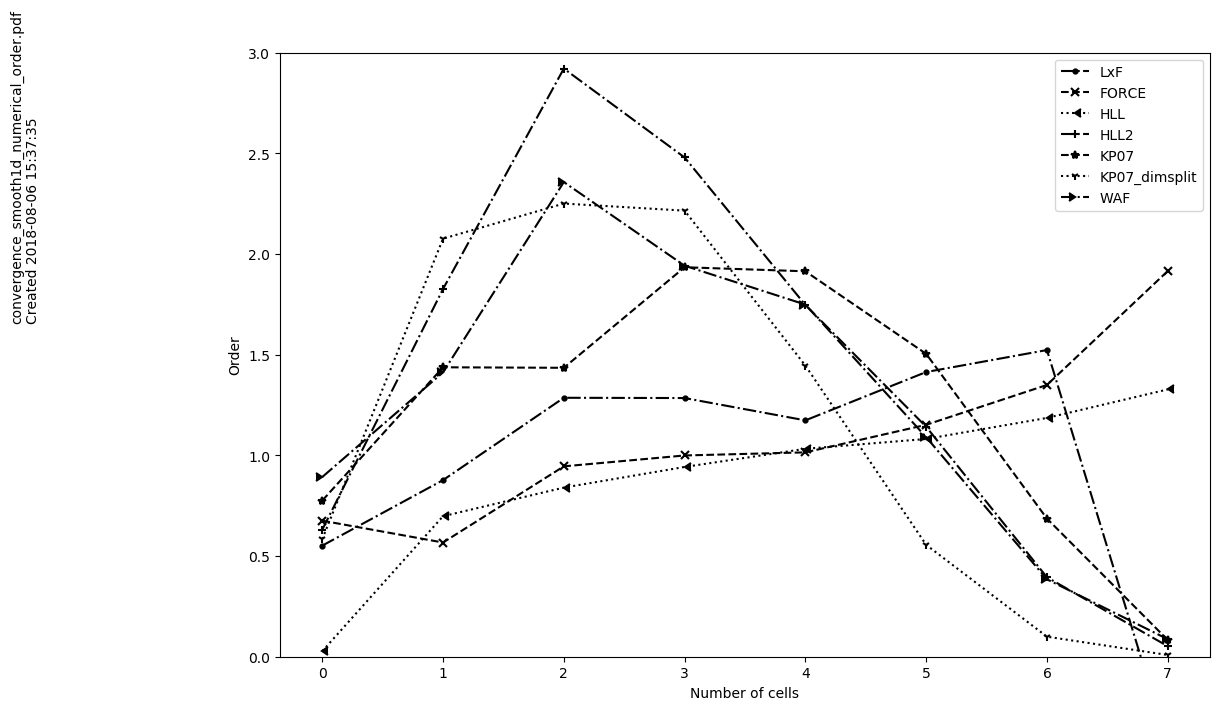

In [14]:
fig = plt.figure()
setBwStyles(fig.gca())

for i, simulator in enumerate(simulators):
    plt.plot(order[i,:], label=simulator.__name__)
    
plt.ylim([0, 3])
plt.xlabel('Number of cells')
plt.ylabel('Order')
plt.legend()
plt.title("Numerical order")
save_figure(fig, 'numerical_order')

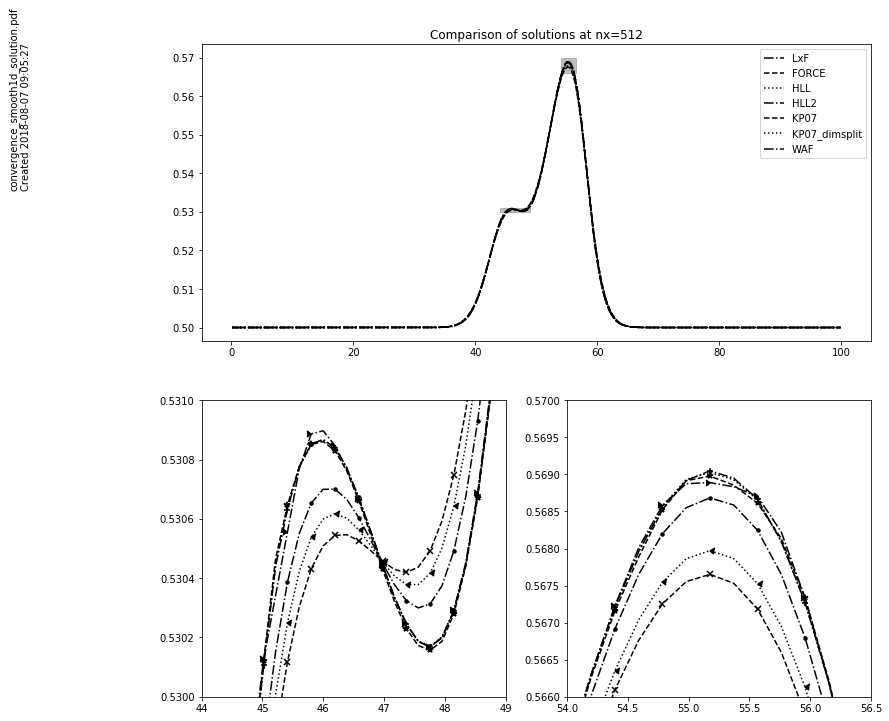

In [34]:
def plot_comparison(nx, **kwargs):
    plot_solution(HLL2.HLL2, reference_nx, 'Reference', marker=' ', linestyle='-')

    for i, simulator in enumerate(simulators):
        plot_solution(simulator, nx, simulator.__name__, **kwargs)


comparison_nx = 512
fig = plt.figure(figsize=(12, 12))
gs = gridspec.GridSpec(2, 2)
    
ax1 = fig.add_subplot(gs[0,:])
setBwStyles(ax1)
for simulator in simulators:
    plot_solution(simulator, comparison_nx, simulator.__name__, marker=' ')
for box_x, box_y in boxes:
    x = np.kron(box_x, np.ones((2)))
    y = np.hstack((box_y, box_y[::-1]))
    fig.gca().fill(x, y, fill=True, linestyle='-', color='gray', alpha=0.5)
plt.title("Comparison of solutions at nx=" + str(comparison_nx))
plt.legend()

ax2 = fig.add_subplot(gs[1,0])
setBwStyles(ax2)
for simulator in simulators:
    plot_solution(simulator, comparison_nx, simulator.__name__, markevery=2)
plt.xlim([44, 49])
plt.ylim([0.53, 0.531])

ax3 = fig.add_subplot(gs[1,1])
setBwStyles(ax3)
setBwStyles(ax2)
for simulator in simulators:
    plot_solution(simulator, comparison_nx, simulator.__name__, markevery=2)
plt.xlim([54, 56.5])
plt.ylim([0.566, 0.57])
    
save_figure(fig, 'solution')

<Figure size 864x864 with 0 Axes>

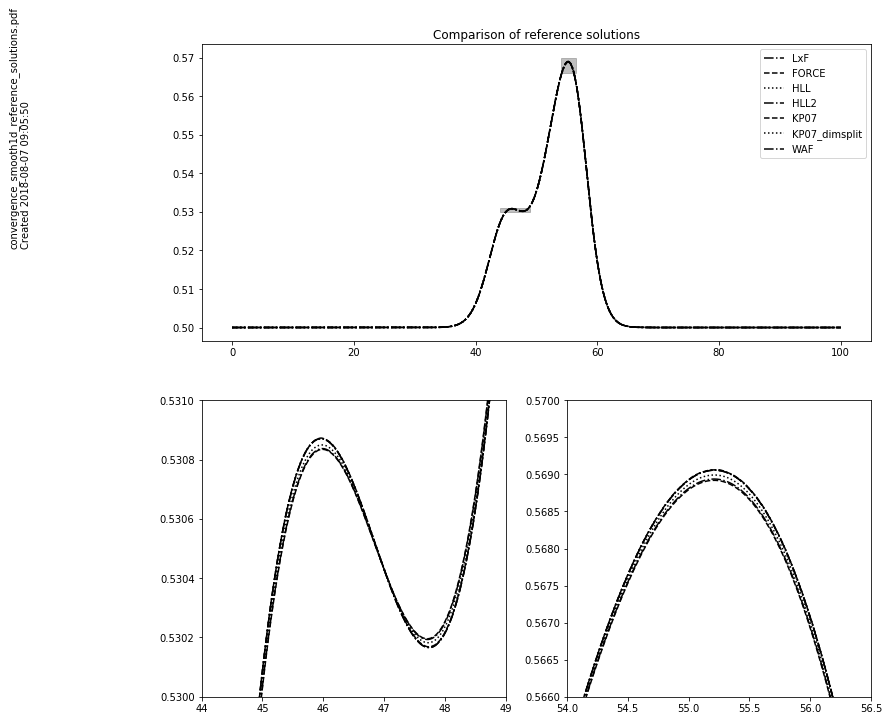

In [35]:
fig = plt.figure(figsize=(12, 12))
gs = gridspec.GridSpec(2, 2)


fig = plt.figure(figsize=(12, 12))
gs = gridspec.GridSpec(2, 2)
    
ax1 = fig.add_subplot(gs[0,:])
setBwStyles(ax1)
for simulator in simulators:
    plot_solution(simulator, reference_nx, simulator.__name__, marker=' ')
for box_x, box_y in boxes:
    x = np.kron(box_x, np.ones((2)))
    y = np.hstack((box_y, box_y[::-1]))
    fig.gca().fill(x, y, fill=True, linestyle='-', color='gray', alpha=0.5)
plt.title("Comparison of reference solutions")
plt.legend()

ax2 = fig.add_subplot(gs[1,0])
setBwStyles(ax2)
for simulator in simulators:
    plot_solution(simulator, reference_nx, simulator.__name__, marker=' ')
plt.xlim([44, 49])
plt.ylim([0.53, 0.531])

ax3 = fig.add_subplot(gs[1,1])
setBwStyles(ax3)
setBwStyles(ax2)
for simulator in simulators:
    plot_solution(simulator, reference_nx, simulator.__name__, marker=' ')
plt.xlim([54, 56.5])
plt.ylim([0.566, 0.57])
    
save_figure(fig, 'reference_solutions')